In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from parse_jfl import * 

In [2]:
lens_design = {
    'Thickness': 0.2,
    'SemiDiameter': 5.61,
}

In [3]:
front_surface_design = [
    {
        'Type': "Standard",
        'Radius': 849.15,
        'Conic': 0.0,
        'SemiDiameter': 1.844,
    },
    {
        'Type': "Fillet",
        'Radius': 0.80,
        'Conic': 0.0,
        'SemiDiameter': 2.282,
        'Center': 1.844,
    },
    {
        'Type': "Line",
        'SemiDiameter': 4.060,
        'EndZ': 1.305,
    },
    {
        'Type': "Fillet",
        'Radius': -0.80,
        'Conic': 0.0,
        'SemiDiameter': 4.50,
        'Center': 4.50
    },
    {
        'Type': "Line",
        'SemiDiameter': 5.61,
        'EndZ': 1.437,
    }
]

In [4]:
back_surface_design = [
    {
        'Type': 'EvenAsphere',
        'Radius': 5.286,
        'Conic': 0.684,
        'SemiDiameter': 2.088,
        'AsphereTerm': 3,
        'AsphereParams': [3.85479E-07,-1.12063E-06,-6.277E-07],
    },
    {
        "Type": "Line",
        "SemiDiameter": 4.101,
        "EndZ": 1.363+lens_design['Thickness'],
    },
    {
        'Type': "Fillet",
        'Radius': -0.80,
        'Conic': 0.0,
        'SemiDiameter': 4.436,
        'Center': 4.436,
    },
    {
        "Type": "Line",
        "SemiDiameter": 5.610,
        "EndZ": 1.437+lens_design['Thickness'],
    },
]


In [5]:
def standard(r, params, z0):
    r_min = r.min()
    c = 1/params['Radius']
    k = params['Conic']
    def core(r):
        return c*r**2/(1+np.sqrt(1-(1+k)*c**2*r**2))
    z = core(r)
    z_min = core(r_min)
    return z - z_min + z0

In [6]:
def fillet(r, params, z0):
    r_min = r.min()
    r_max = r.max()
    c = 1/params['Radius']
    k = params['Conic']
    r0 = params['Center']
    def core(r):
        return c*(r-r0)**2/(1+np.sqrt(1-(1+k)*c**2*(r-r0)**2))
    z = core(r)
    z_min = core(r_min)
    return z - z_min + z0

In [7]:
def even_asphere(r,params,z0): 
    c = 1/params['Radius'] 
    k = params['Conic'] 
    def core(r):
        z = c*r**2/(1+np.sqrt(1-(1+k)*c**2*r**2)) 
        asphere = 0 
        for i in range(params['AsphereTerm']): 
            asphere += params['AsphereParams'][i]*r**(2*(i+1)) 
        return z + asphere
    z = core(r)
    z_min = core(r.min())
    return z -z_min + z0

In [8]:
def line(r, params, z0):
    delta_z = params['EndZ'] - z0
    start_r = r.min()
    delta_r = params['SemiDiameter'] - start_r
    z = delta_z * (r - start_r) / delta_r
    return z + z0

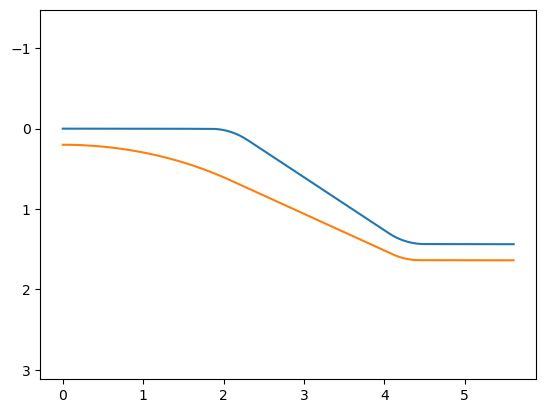

In [9]:
step = 0.0025
surface_sag = [{},{}]
for i, surface_design in enumerate([front_surface_design, back_surface_design]):
    r = np.arange(0, lens_design['SemiDiameter'], step)
    z = np.zeros_like(r)

    z0 = 0 if surface_design==front_surface_design else lens_design['Thickness']
    z[0] = z0   
    r0 = 0
    for surface in surface_design:
        ROI_index = (r > r0) & (r <= surface['SemiDiameter'])
        r_ROI = r[ROI_index]
        try:
            if surface['Type'] == 'Standard':
                z_ROI = standard(r_ROI, surface, z0)  
            elif surface['Type'] == 'EvenAsphere':
                z_ROI = even_asphere(r_ROI, surface, z0)
            elif surface['Type'] == 'Line':
                z_ROI = line(r_ROI, surface, z0)
            elif surface['Type'] == 'Fillet':
                z_ROI = fillet(r_ROI, surface, z0)
            z[ROI_index] = z_ROI

            z0 = z_ROI[-1]
        except :
            print('Error')
            break
        r0 = surface['SemiDiameter']
    surface_sag[i]['r'] = r
    surface_sag[i]['z'] = z
    plt.plot(r, z)
plt.axis('equal')
# 反转坐标轴
plt.gca().invert_yaxis()
plt.show()
